# Accessing CORDEX datasets from ESGF

In this example, we will show some ways to access ESGF data using opendap access to ESGF. We want to avoid downloading files to make our research more automatic and reproducable for others.

In [2]:
import os
import xarray as xr
import cf_xarray as cfxr
import pyesgf
from pyesgf.logon import LogonManager
from pyesgf.search import SearchConnection

print(pyesgf.__version__)

lm = LogonManager(verify=True)

if not lm.is_logged_on():
    myproxy_host = "esgf-data.dkrz.de"
    lm.logon(
        hostname=myproxy_host,
        username=os.environ["ESGF_USER"],
        password=os.environ["ESGF_PASSWORD"],
        interactive=False,
        bootstrap=True,
    )


print(f"logged on: {lm.is_logged_on()}")

0.3.1
logged on: True


Theoretically, we can find out the opendap URL for a CORDEX dataset by browsing through the [ESGF Web API](https://esgf-data.dkrz.de/search/cordex-dkrz/). Let's assume, we have found out the URL and want to access that dataset. We can simply use `xr.open_dataset` for this assuming we have `netcdf4` installed.

In [2]:
ds = xr.open_dataset(
    "http://esgf1.dkrz.de/thredds/dodsC/cordex/cordex/output/EUR-11/GERICS/ECMWF-ERAINT/evaluation/r0i0p0/GERICS-REMO2015/v1/fx/orog/v20180813/orog_EUR-11_ECMWF-ERAINT_evaluation_r0i0p0_GERICS-REMO2015_v1_fx.nc"
)

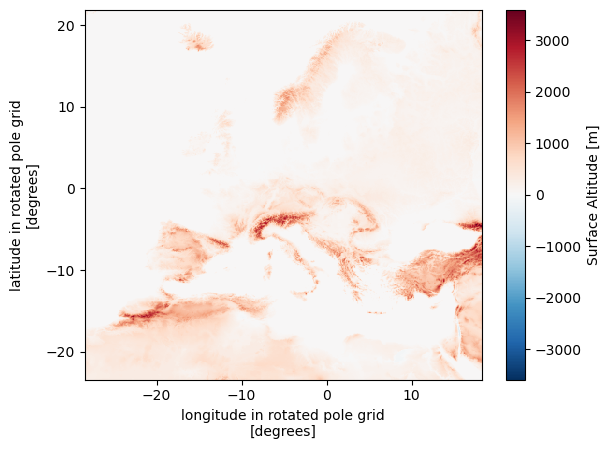

In [3]:
ds.orog.plot()

## Search for URLs

In [4]:
import requests
import numpy


def parse_urls(response):
    types = {}
    for r in response:
        url_type = r.split("|")[1]
        if "opendap" in url_type:
            types["opendap"] = r.split("|")[0][0:-5]
        else:
            types[url_type] = r.split("|")[0]
    return types
    # return {r.split("|")[1]: r.split("|")[0] for r in response}


def parse_result(response):
    files = response.json()["response"]["docs"]
    # return files
    # result = dict.fromkeys([f['dataset_id'] for f in files], {})
    result = {f["dataset_id"]: {} for f in files}
    for f in files:
        id = f["dataset_id"]
        urls = parse_urls(f["url"])
        for url_type, url in urls.items():
            if url_type in result[id].keys():
                result[id][url_type].append(url)
            else:
                result[id][url_type] = [url]
        # result[id].update(urls)
    return result


def esgf_search(
    url="https://esgf-node.llnl.gov/esg-search/search",
    files_type="OPENDAP",
    local_node=True,
    project="CORDEX",
    **search,
):
    params = dict(
        project=project, type="File", format="application/solr+json", limit=500
    )
    params.update(search)
    response = requests.get(url, params)
    return parse_result(response)

In [5]:
result = esgf_search(
    url="http://esgf-data.dkrz.de/esg-search/search",
    project=["CORDEX", "CORDEX-Reklies"],
    time_frequency="mon",
    variable="tas",
    experiment=["historical", "rcp26", "rcp45", "rcp85"],
    domain="EUR-11",
    ensemble="r1i1p1",
)
len(result)

59

In [7]:
def open_mfdataset(
    files,
    use_cftime=True,
    parallel=True,
    data_vars="minimal",
    chunks={},
    coords="minimal",
    compat="override",
    drop=None,
    **kwargs,
):
    """optimized function for opening large cf datasets.

    based on https://github.com/pydata/xarray/issues/1385#issuecomment-561920115

    """

    def drop_all_coords(ds):
        # ds = ds.drop(drop)
        return ds.reset_coords(drop=True)

    ds = xr.open_mfdataset(
        files,
        parallel=parallel,
        decode_times=False,
        combine="by_coords",
        preprocess=drop_all_coords,
        decode_cf=False,
        chunks=chunks,
        data_vars=data_vars,
        coords="minimal",
        compat="override",
        **kwargs,
    )
    return xr.decode_cf(ds, use_cftime=use_cftime)

In [8]:
urls = result[
    "cordex.output.EUR-11.DMI.ICHEC-EC-EARTH.historical.r1i1p1.HIRHAM5.v1.mon.tas.v20190108|cordexesg.dmi.dk"
]["opendap"]
%time ds = open_mfdataset(urls, parallel=True, chunks={})

CPU times: user 474 ms, sys: 313 ms, total: 787 ms
Wall time: 3.33 s


In [9]:
%time mean = ds.tas.groupby('time.year').mean('time').cf.mean(('X', 'Y')).compute()

CPU times: user 1.11 s, sys: 189 ms, total: 1.3 s
Wall time: 22.4 s


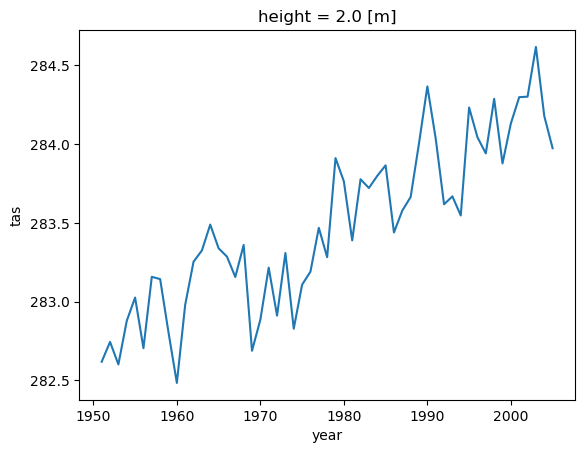

In [10]:
mean.plot()